# Comparison of Briere models and flexTPC on antibiotic dataset

In [30]:
import numpy as np
import pandas as pd
import random

random.seed(42)

from matplotlib import pyplot as plt

from scipy.optimize import minimize
from sklearn.model_selection import LeaveOneOut

In [31]:
def briere1(T, Tmin=10.0, Tmax=50.0, c=1.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) + 0.5 * np.log(Tmax - T[cond]))
    return result

def briere2(T, Tmin=10.0, Tmax=50.0, c=1.0, b=2.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) +  np.log(Tmax - T[cond]) / b)
    return result

# Fully biologically interpretable parametrization of flexTPC model
def flexTPC(T, Tmin=10.0, Tmax=50.0, rmax=1.0, α=0.8, β=0.2):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    s = α * (1.0 - α) / β**2
    result[cond] = rmax * np.exp(s * (α * (np.log(T[cond] - Tmin) - np.log(α)) +
                                      (1 - α) * (np.log(Tmax - T[cond]) - np.log(1 - α) )
                                       - np.log(Tmax - Tmin)))
    return result

In [32]:
def nloglik2(θ, Tdata, rdata, model=flexTPC):
    params, σ2 = θ[:-1], θ[-1]
    Tmin, Tmax = θ[:2]
    outside = (Tdata < Tmin) | (Tdata > Tmax)
    n = len(rdata)
    return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata - model(Tdata, *params))**2 / σ2))
    
def AIC(nll, p):
    return 2 * nll + 2 * p 

def BIC(nll, n, p):
    return 2 * nll + p * np.log(n)

## E. coli antibiotics dataset

In [33]:
abcoli = pd.read_csv("ab_data.csv")
single = abcoli[(abcoli["drug2name"] == "WT")]
drugs = ['AMP',
 'CLI',
 'CPR',
 'ERY',
 'FOX',
 'GEN',
 'LVX',
 'NTR',
 'STR',
 'TET',
 'TMP',
 'TOB',
 'WT']

In [34]:
drugs

['AMP',
 'CLI',
 'CPR',
 'ERY',
 'FOX',
 'GEN',
 'LVX',
 'NTR',
 'STR',
 'TET',
 'TMP',
 'TOB',
 'WT']

In [35]:
single

,drug1name,drug2name,drug1num,drug2num,T,t,sample,OD
28,NTR,WT,8.0,13.0,37.0,24.0,1.0,0.6244
29,NTR,WT,8.0,13.0,37.0,24.0,2.0,0.6865
30,NTR,WT,8.0,13.0,37.0,24.0,3.0,0.7640
31,NTR,WT,8.0,13.0,37.0,24.0,4.0,0.7984
32,NTR,WT,8.0,13.0,22.0,24.0,1.0,0.0139
...,...,...,...,...,...,...,...,...
1927,TET,WT,10.0,13.0,44.0,24.0,4.0,0.3349
1928,TET,WT,10.0,13.0,30.0,24.0,1.0,0.3772
1929,TET,WT,10.0,13.0,30.0,24.0,2.0,0.3865
1930,TET,WT,10.0,13.0,30.0,24.0,3.0,0.3883


In [36]:
abdata = single.groupby(["drug1name", "T"], as_index=False).agg({'OD':'mean'})
#Set low values to zero

#abdata["OD"][abdata["OD"] < 0.02] = 0.0

In [37]:
abdata[abdata["OD"] < 0.0]

,drug1name,T,OD


In [38]:
abdata[abdata["drug1name"] == "AMP"]

,drug1name,T,OD
0,AMP,22.0,0.255500
1,AMP,25.0,0.399700
2,AMP,30.0,0.717800
3,AMP,37.0,0.713775
4,AMP,41.0,0.625300
5,AMP,44.0,0.001950
6,AMP,46.0,0.002450


In [39]:
def nloglikab(θ, Tdata, rdata, model=flexTPC):
    params, σ2 = θ[:-1], θ[-1]
    Tmin, Tmax = θ[:2]
    return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata 
                                                    - model(Tdata, *params))**2 / σ2))

In [40]:
initial_flex = {drug:[20.0, 46.5, 0.7, 0.7, 0.2, 0.005] for drug in drugs}
#initial_mb["GEN"] = [20.0, 46.5, 0.5, 0.7, 2.0, 0.005]
#initial_mb["STR"] = [20.0, 46.5, 0.5, 0.7, 2.0, 0.005]
#initial_mb["TOB"] = [20.0, 46.5, 0.5, 0.7, 2.0, 0.005]
#initial_mb["ERY"] = [20.0, 46.5, 0.5, 0.7, 4.0, 0.005]
#initial_mb["AMP"] = [15.0, 46.5, 0.7, 0.7, 2.0, 0.005]

initial_b1 = {drug:[20.0, 46.5, 3e-4, 0.005] for drug in drugs}
initial_b2 = {drug:[20.0, 46.5, 3e-4, 2.0, 0.005] for drug in drugs}

In [41]:
loo = LeaveOneOut()
loo.get_n_splits(abdata["T"][abdata["drug1name"] == "WT"])

7

In [42]:
initial_flex

{'AMP': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'CLI': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'CPR': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'ERY': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'FOX': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'GEN': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'LVX': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'NTR': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'STR': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'TET': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'TMP': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'TOB': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005],
 'WT': [20.0, 46.5, 0.7, 0.7, 0.2, 0.005]}

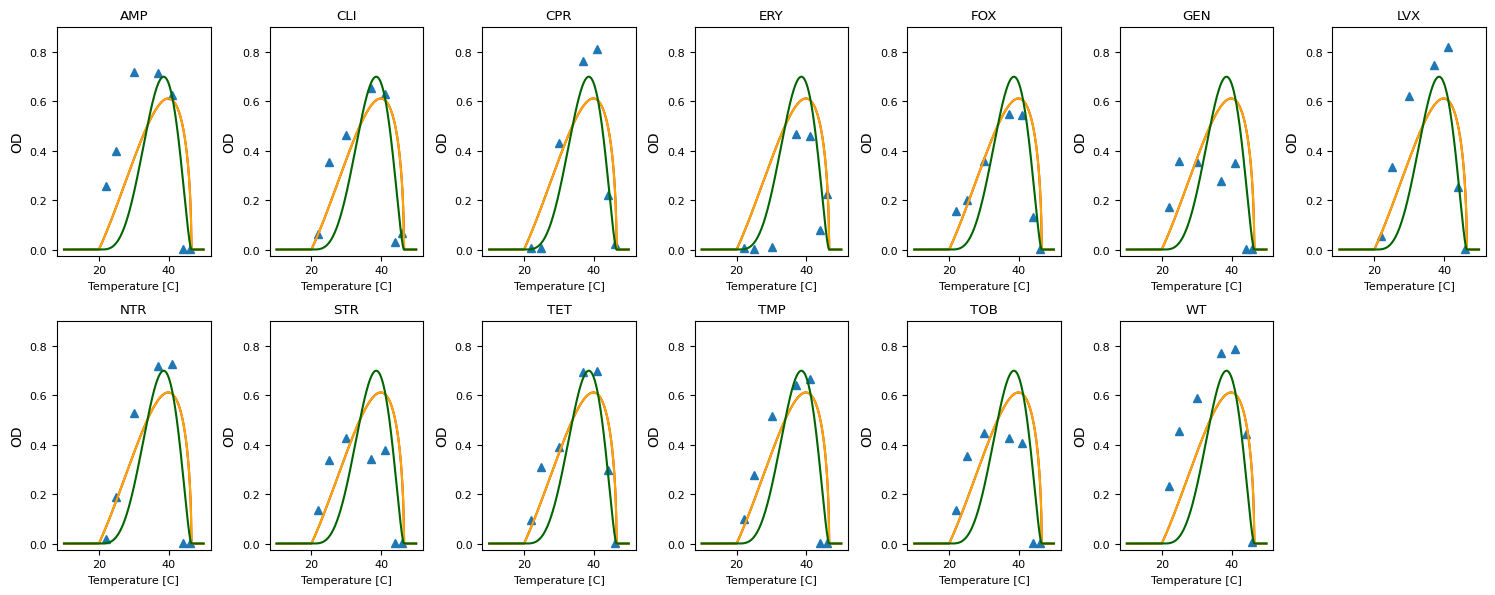

In [43]:
T = np.arange(10, 50, 0.001)
plt.figure(figsize=(15, 6))


for i, drug in enumerate(drugs):
    subset = abdata[abdata["drug1name"] == drug]
    
    plt.subplot(2, 7, i+1)
    # Plot datapoints.
    Tdata = subset["T"]
    rdata = subset["OD"]

    plt.plot(Tdata, rdata, '^')
    
    # Plot initial parameters curves by Briere.
    par = initial_b1[drug]    
    plt.plot(T, briere1(T, *par[:-1]), color="firebrick")
    
    par = initial_b2[drug]
    plt.plot(T, briere2(T, *par[:-1]), color="orange")
    
    par = initial_flex[drug]
    plt.plot(T, flexTPC(T, *par[:-1]), color="darkgreen")
    

    plt.ylim(-0.025, 0.9)
    plt.xlabel("Temperature [C]")
    plt.ylabel("OD", fontsize=10)
    plt.title(drug)
plt.tight_layout()

In [71]:
# LOOCV

params = {"flexTPC":{}, "b1":{}, "b2":{}}
models = ["b1", "b2", "flexTPC"]
loocv_nll = {model:{drug:[] for drug in drugs } for model in models}

method = "Nelder-Mead"
for i, drug in enumerate(drugs):
    subset = abdata[abdata["drug1name"] == drug]
    Tdata = np.array(subset["T"])
    rdata = np.array(subset["OD"])
    
    print(drug)
    print("numsplits:", loo.get_n_splits(Tdata))
    
    for train, test in loo.split(Tdata):
        T_train, r_train = Tdata[train], rdata[train]
        T_test, r_test = Tdata[test], rdata[test]
    

        params["b1"][drug] = minimize(nloglikab, initial_b1[drug],
                           bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),  
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere1), options={"maxiter":100000}, method=method)
        θ = params["b1"][drug]["x"]
        loocv_nll["b1"][drug].append(nloglikab(θ, T_test, r_test, model=briere1))

        params["b2"][drug] = minimize(nloglikab, initial_b2[drug],
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),
                                    (1.0, 20.0),
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
        θ = params["b2"][drug]["x"]
        loocv_nll["b2"][drug].append(nloglikab(θ, T_test, r_test, model=briere2))

        
        params["flexTPC"][drug] = minimize(nloglikab, initial_flex[drug], #Check nloglikab vs nloglok
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 1.0), 
                                    (0.1, 0.95), 
                                    (0.0, 2.0), 
                                    (0, 0.01)],
                      args=(Tdata, rdata), options={"maxiter":100000}, method=method)
        θ = params["flexTPC"][drug]["x"]
        loocv_nll["flexTPC"][drug].append(nloglikab(θ, T_test, r_test, model=flexTPC))

AMP
numsplits: 7
CLI
numsplits: 7
CPR
numsplits: 7
ERY
numsplits: 7
FOX
numsplits: 7
GEN
numsplits: 7
LVX
numsplits: 7
NTR
numsplits: 7
STR
numsplits: 7
TET
numsplits: 7
TMP
numsplits: 7


/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14925/1310441239.py:4: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14925/1310441239.py:4: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14925/1310441239.py:4: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata


TOB
numsplits: 7
WT
numsplits: 7


In [72]:
params = {"flexTPC":{}, "b1":{}, "b2":{}}
models = ["b1", "b2", "flexTPC"]
method = "Nelder-Mead"
for i, drug in enumerate(drugs):
    subset = abdata[abdata["drug1name"] == drug]
    Tdata = np.array(subset["T"])
    rdata = np.array(subset["OD"])    

    params["b1"][drug] = minimize(nloglikab, initial_b1[drug],
                           bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),  
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere1), options={"maxiter":100000}, method=method)
    
    params["b2"][drug] = minimize(nloglikab, initial_b2[drug],
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 10.0),
                                    (1.0, 20.0),
                                    (0, 0.01)],
                      args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
    params["flexTPC"][drug] = minimize(nloglikab, initial_flex[drug], #nloglikab vs nloglok
                            bounds=[(0.0, 20.0), 
                                    (30.0, 60.0), 
                                    (0.0, 1.0), 
                                    (0.1, 0.95), 
                                    (0.0, 2.0), 
                                    (0, 0.01)],
                      args=(Tdata, rdata), options={"maxiter":100000}, method=method)
    

/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14925/1310441239.py:4: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14925/1310441239.py:4: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_14925/1310441239.py:4: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (len(rdata) * np.log(2*np.pi*σ2) + np.sum((rdata


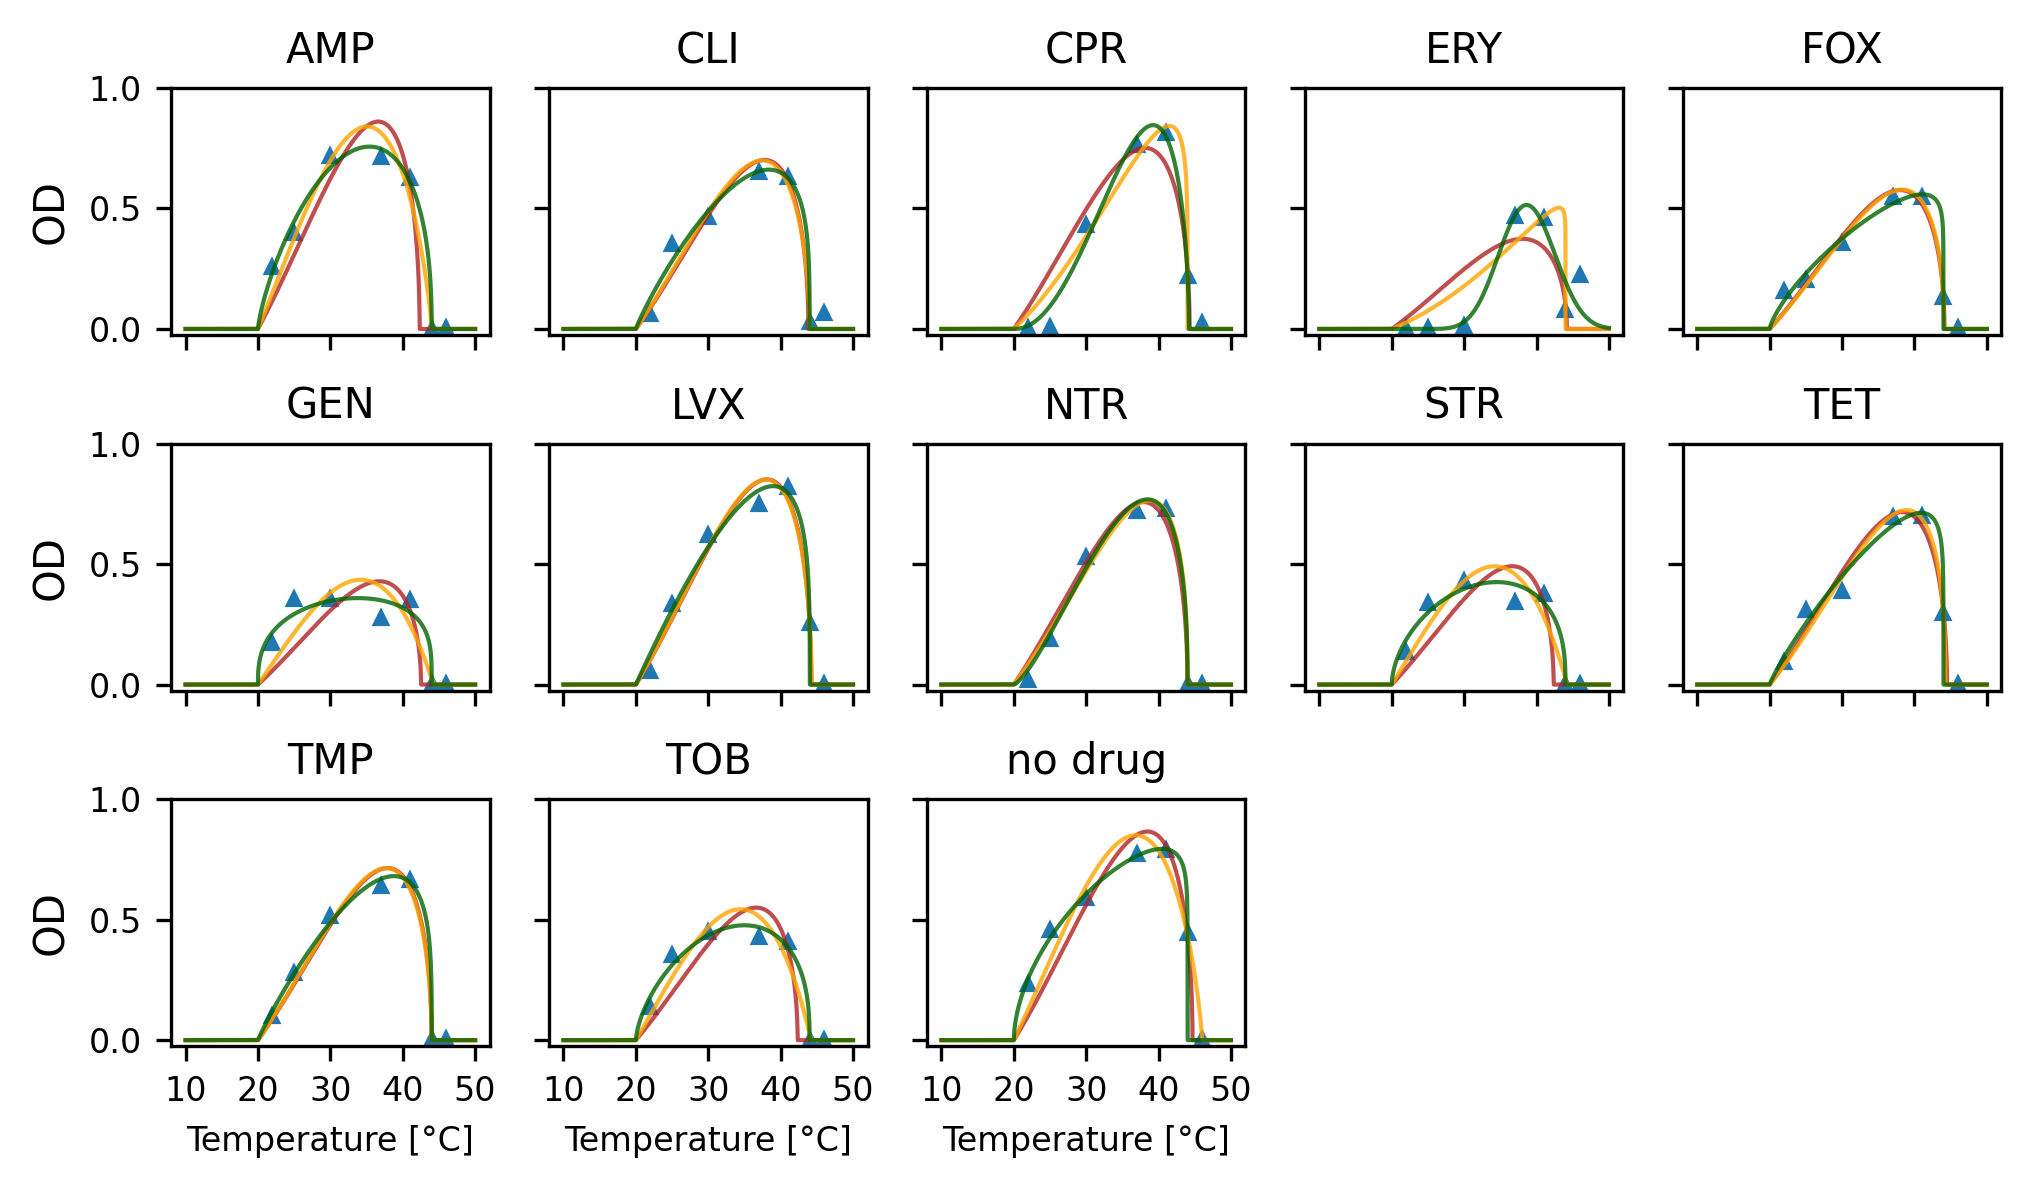

In [73]:
T = np.arange(10, 50, 0.001)

fig, axarr = plt.subplots(3, 5, figsize=(6.81102, 4), dpi=300, sharex=True, sharey=True)

plt.rcParams.update({'font.size': 8})

for i, drug in enumerate(drugs):
    ax = axarr[i // 5, i % 5]
    subset = abdata[abdata["drug1name"] == drug]

    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_yticks([0, 0.5, 1])


    #plt.subplot(3, 5, i+1)
    # Plot datapoints.
    Tdata = subset["T"]
    rdata = subset["OD"]

    ax.plot(Tdata, rdata, '^', markersize=3)
    
    # Plot fitted curves by Briere.
    #par = initial_b1[drug]
    par = params["b1"][drug]["x"]
    
    ax.plot(T, briere1(T, *par[:-1]), color="firebrick", linewidth=1, alpha=0.8)
    
    #par = initial_b2[drug]
    par = params["b2"][drug]["x"]
    ax.plot(T, briere2(T, *par[:-1]), color="orange", linewidth=1, alpha=0.8)
    
             
    par = params["flexTPC"][drug]["x"]
    #par = initial_mb[drug]
    ax.plot(T, flexTPC(T, *par[:-1]), color="darkgreen", linewidth=1, alpha=0.8)
    

    ax.set_ylim(-0.025, 1.0)

    if drug != 'WT':
        ax.set_title(drug, fontsize=10)
    else:
        ax.set_title('no drug', fontsize=10)
    if drug in ("TMP", "TOB", "WT"):
        ax.set_xlabel("Temperature [°C]", fontsize=8)
    if drug in ("AMP", "GEN", "TMP"):
        ax.set_ylabel("OD", fontsize=10)
        
axarr[-1, -1].axis("off")
axarr[-1, -2].axis("off")


#ERY
#rect = plt.Rectangle(
#        # (lower-left corner), width, height
#        (0.63, 0.69), 0.18, 0.29, fill=False, color="k", lw=1.5, 
#        zorder=1000, transform=fig.transFigure, figure=fig
#    )

#GEN
#rect2 = plt.Rectangle(
#        # (lower-left corner), width, height
#        (0.04, 0.4), 0.22, 0.29, fill=False, color="k", lw=1.5, 
#        zorder=1000, transform=fig.transFigure, figure=fig
#    )

#fig.patches.extend([rect, rect2])
plt.tight_layout()

plt.savefig("abcoli.svg")
plt.savefig("abcoli.pdf")
plt.savefig("abcoli.png")

In [83]:
n_params = {'b1':4, 'b2':5, 'flexTPC':6} # Includes standard deviation.
param_matrix = {model:np.zeros((13, n_params[model])) for model in models}

for model in models:
    for i, drug in enumerate(drugs):
        param_matrix[model][i, ] = params[model][drug]["x"]

colnames = {'b1':['Tmin', 'Tmax', 'c', 'sigma2'],
            'b2':['Tmin', 'Tmax', 'c', 'm', 'sigma2'],
            'flexTPC':['Tmin', 'Tmax', 'rmax', 'alpha', 'beta', 'sigma2']}

param_df = {model:pd.DataFrame(param_matrix[model], columns=colnames[model]) for model in models}
for model in models:
    param_df[model]['drug'] = drugs
    param_df[model] = param_df[model][['drug'] + colnames[model]]
    param_df[model].to_csv(f'abcoli_params_{model}.csv', index=False)

In [75]:
param_df['flexTPC']

,drug,Tmin,Tmax,rmax,alpha,beta,sigma2
0,AMP,20.0,44.000003,0.756763,0.642037,0.437539,0.000913
1,CLI,20.0,44.000031,0.661223,0.765370,0.387482,0.002158
2,CPR,20.0,44.195263,0.845881,0.795025,0.243240,0.001969
3,ERY,20.0,60.000000,0.514508,0.465700,0.097313,0.005200
4,FOX,20.0,44.000001,0.558624,0.880069,0.352395,0.000517
5,GEN,20.0,44.000000,0.358805,0.574757,0.617911,0.001757
6,LVX,20.0,44.026381,0.823561,0.788428,0.362861,0.001786
7,NTR,20.0,44.000001,0.768543,0.769126,0.313968,0.000812
8,STR,20.0,44.000015,0.425230,0.604259,0.500803,0.001711
9,TET,20.0,44.001389,0.712707,0.872408,0.331231,0.001259


In [76]:
nll = np.zeros((len(drugs), len(models)))
aic = np.zeros((len(drugs), len(models)))
bic = np.zeros((len(drugs), len(models)))
loo_nll = np.zeros((len(drugs), len(models)))

p = [4, 5, 6] # Number of parameters.
n = 7 # Number of datapoints.

for i, d in enumerate(drugs):
    for j, m in enumerate(models): 
        nll[i, j] = params[m][d]["fun"]
        aic[i, j] = AIC(nll[i, j], p[j])
        bic[i, j] = BIC(nll[i, j], n, p[j])
        loo_nll[i, j] = np.mean(loocv_nll[m][d])

In [77]:
drugs

['AMP',
 'CLI',
 'CPR',
 'ERY',
 'FOX',
 'GEN',
 'LVX',
 'NTR',
 'STR',
 'TET',
 'TMP',
 'TOB',
 'WT']

In [78]:
for drug in drugs:
    print(drug, np.round(params["flexTPC"][drug]["x"], 3) )

AMP [2.00e+01 4.40e+01 7.57e-01 6.42e-01 4.38e-01 1.00e-03]
CLI [2.00e+01 4.40e+01 6.61e-01 7.65e-01 3.87e-01 2.00e-03]
CPR [2.0000e+01 4.4195e+01 8.4600e-01 7.9500e-01 2.4300e-01 2.0000e-03]
ERY [2.00e+01 6.00e+01 5.15e-01 4.66e-01 9.70e-02 5.00e-03]
FOX [2.00e+01 4.40e+01 5.59e-01 8.80e-01 3.52e-01 1.00e-03]
GEN [2.00e+01 4.40e+01 3.59e-01 5.75e-01 6.18e-01 2.00e-03]
LVX [2.0000e+01 4.4026e+01 8.2400e-01 7.8800e-01 3.6300e-01 2.0000e-03]
NTR [2.00e+01 4.40e+01 7.69e-01 7.69e-01 3.14e-01 1.00e-03]
STR [2.00e+01 4.40e+01 4.25e-01 6.04e-01 5.01e-01 2.00e-03]
TET [2.0000e+01 4.4001e+01 7.1300e-01 8.7200e-01 3.3100e-01 1.0000e-03]
TMP [20.    44.     0.681  0.782  0.377  0.   ]
TOB [2.00e+01 4.40e+01 4.77e-01 6.24e-01 4.73e-01 1.00e-03]
WT [20.    44.003  0.794  0.853  0.437  0.   ]


In [79]:
dfAIC = pd.DataFrame(np.round(aic, 2), columns=models, index=drugs)
dfBIC = pd.DataFrame(np.round(bic, 2), columns=models, index=drugs)
dfLOOCV = pd.DataFrame(np.round(loo_nll, 2), columns=models, index=drugs)

In [80]:
dfAIC

,b1,b2,flexTPC
AMP,-5.56,-8.64,-17.12
CLI,-11.98,-10.51,-11.38
CPR,-2.92,-7.16,-11.75
ERY,3.28,0.25,-4.95
FOX,-18.14,-16.31,-21.11
GEN,-3.16,-3.96,-11.56
LVX,-12.93,-10.96,-12.43
NTR,-16.03,-16.47,-17.42
STR,-5.39,-7.42,-12.87
TET,-15.07,-13.83,-14.88


In [81]:
dfBIC

,b1,b2,flexTPC
AMP,-5.78,-8.91,-17.45
CLI,-12.19,-10.78,-11.70
CPR,-3.14,-7.43,-12.07
ERY,3.07,-0.02,-5.27
FOX,-18.35,-16.58,-21.43
GEN,-3.38,-4.23,-11.88
LVX,-13.15,-11.23,-12.75
NTR,-16.25,-16.74,-17.74
STR,-5.61,-7.69,-13.19
TET,-15.28,-14.10,-15.20


In [82]:
dfLOOCV

,b1,b2,flexTPC
AMP,-0.97,-1.33,-2.08
CLI,-1.43,-1.47,-1.67
CPR,-0.78,-1.23,-1.70
ERY,-0.34,-0.70,-1.21
FOX,-1.87,-1.88,-2.36
GEN,-0.80,-1.00,-1.68
LVX,-1.50,-1.50,-1.74
NTR,-1.72,-1.89,-2.10
STR,-0.96,-1.24,-1.78
TET,-1.65,-1.70,-1.92
